* Préparation des données
  - Définir un pipeline de prétraitement des textes (variable « Caption »), en appliquant les techniques étudiées dans les TP du module correspondant (suppression des stopwords, lemmatisation, suppression des caractères spéciaux, etc.).
  - Encoder les textes avec un modèle Word2Vec ou Glove pré-entraîné.
  - Appliquer la même répartition que pour les images (70% train, 15% validation, 15% test) en conservant l’ordre des instances.
* Modèle baseline
  - Réaliser un model baseline avec des algorithmes de Machine Learning classique. Expérimenter deux algorithmes de classification, par exemple : Logistic Regression, SVM, Random Forest, etc.
* Expérimentation avec deep learning
  - Utiliser LSTM et Bi-LSTM pour capturer la dépendance contextuelle des mots, ainsi que 1D CNN pour extraire des motifs locaux dans les textes.
  - Testez différentes architectures et optimiseurs et documentez les résultats.
  - Expérimentation 1 : Entraîner un modèle LSTM « from scratch », avec une couche d’embedding.
  - Expérimentation 2 : Utiliser un embedding pré entraîné (Word2Vec/Glove).
  - Expérimentation 3 : Construire une architecture hybride combinant LSTM et 1D CNN
* Comparaison des résultats et choix du modèle final
  - Comparer les performances des différents modèles expérimentés à l’aide de la matrice de confusion et des métriques sélectionnées, adaptées à la classification multi-label.
  - Justifier le choix du modèle retenu.
* Analyse des résultats
  - Afficher quelques textes de test avec les prédictions etles scores de confiance correspondants.
  - Utiliser des techniques d’interprétation, comme LIME, pour mieux comprendre les décisions du modèle.
  - Examiner des erreurs de prédiction et essayer d’identifier des explications.
  - Interpréter les résultats et proposer des pistes d’amélioration.

####Préparation des données
  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
import nltk

import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score, average_precision_score

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/IA/projet_final/data/data_multimodal_class/train_split.csv')
test_df = pd.read_csv('/content/drive/MyDrive/IA/projet_final/data/data_multimodal_class/test_split.csv')
val_df = pd.read_csv('/content/drive/MyDrive/IA/projet_final/data/data_multimodal_class/val_split.csv')

In [4]:
def convert_to_list(labels):
    return [label.split(' ') for label in labels]

train_df['Labels'] = convert_to_list(train_df['Labels'])
val_df['Labels'] = convert_to_list(val_df['Labels'])
test_df['Labels'] = convert_to_list(test_df['Labels'])

In [5]:
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_df['Labels'])
val_labels   = mlb.transform(val_df['Labels'])
test_labels  = mlb.transform(test_df['Labels'])

In [6]:
# get number of classes
classes_nbr = (len(mlb.__dict__['classes_']))
classes_nbr

16

In [7]:
def process_labels(labels):
    return tf.convert_to_tensor(labels, dtype=tf.float32)

*Juste car au depart on avait 18 labels et après suppression des labels 1 et 14, il nous reste donc 16.*

In [8]:
train_df['Caption']

,Caption
0,A dozen cats are lounging around on the futon.
1,A large cat sitting on top of a chair in a li...
2,A horse pulled carriage on a city street.
3,A man holding a cat sitting in front of a lapt...
4,a number of kites in the sky with a kite on th...
...,...
11101,A black and white cat peering over the top of ...
11102,A person riding on the back of a horse on a hi...
11103,A stop light is viewed from behind a dashboard.
11104,There us an image off the snow coveted mountains


Définir un pipeline de prétraitement des textes (variable « Caption »), en appliquant les techniques étudiées dans les TP du module correspondant (suppression des stopwords, lemmatisation, suppression des caractères spéciaux, etc.).

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [11]:
def preprocess_text(sentence: str) -> str:

    sentence = sentence.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [12]:
X_train = train_df["Caption"].apply(preprocess_text).tolist()
X_test = test_df["Caption"].apply(preprocess_text).tolist()
X_val = val_df["Caption"].apply(preprocess_text).tolist()

In [13]:
X_train[0]

'dozen cats lounging around futon '

Encoder les textes avec un modèle Word2Vec ou Glove pré-entraîné.
  

In [14]:
#pip install gensim

In [15]:
import gensim
from gensim.models import word2vec, KeyedVectors

In [16]:
#!unzip "/content/drive/MyDrive/IA/projet_final/glove.6B.zip"

In [17]:
model_glove = KeyedVectors.load_word2vec_format("/content/glove.6B.50d.txt", binary=False, no_header=True)

In [18]:
def encode_caption(caption, model_glove, embedding_dim=50):
    words = caption.split()
    encoded_caption = []
    for word in words:
        if word in model_glove:
            encoded_caption.append(model_glove[word])
        else:
            encoded_caption.append(np.zeros(embedding_dim))

    return np.array(encoded_caption)

encoded_X_train = [encode_caption(caption, model_glove) for caption in X_train]
encoded_X_test = [encode_caption(caption, model_glove) for caption in X_test]
encoded_X_val = [encode_caption(caption, model_glove) for caption in X_val]

In [19]:
# Fonction pour aplatir les embeddings (moyenne des vecteurs mots)
def flatten_embedding(embedding):
    if len(embedding) == 0:
        return np.zeros(50)  # Si le texte est vide, retourne un vecteur nul
    return np.mean(embedding, axis=0)  # Moyenne des vecteurs mots

In [20]:
# Applatir tous les embeddings pour obtenir un vecteur fixe de 50 dimensions
encoded_X_train = np.array([flatten_embedding(emb) for emb in encoded_X_train])
encoded_X_val   = np.array([flatten_embedding(emb) for emb in encoded_X_val])
encoded_X_test  = np.array([flatten_embedding(emb) for emb in encoded_X_test])

Appliquer la même répartition que pour les images (70% train, 15% validation, 15% test) en conservant l’ordre des instances.

*Nous avons déjà splitté les données lorsqu'on faisait la répartition des images.*

####Modèle baseline


Réaliser un model baseline avec des algorithmes de Machine Learning classique. Expérimenter deux algorithmes de classification, par exemple : Logistic Regression, SVM, Random Forest, etc.

*Nous allons entraîner un logistic regressor et un random forest.*

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

#Import OneVsRestClassifier, une stratégie de classification multilabel.
from sklearn.multiclass import OneVsRestClassifier


# Create a multi-label classifier using OneVsRestClassifier
lr = OneVsRestClassifier(LogisticRegression(max_iter=500, solver='lbfgs'))

lr.fit(encoded_X_train, train_labels)
y_pred = lr.predict(encoded_X_test)
f1 = f1_score(test_labels, y_pred, average='weighted')

print(f"F1-score : {f1:.4f}")

F1-score : 0.5270


*OneVsRestClassifier permet d'entraîner un modèle indépendant pour chaque classe et fait une prédiction binaire (présence ou absence) pour chaque label.*

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

# Création du classifieur Random Forest multilabel
rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))

rf.fit(encoded_X_train, train_labels)
y_pred = rf.predict(encoded_X_test)
f1 = f1_score(test_labels, y_pred, average='weighted')

print(f"F1-score : {f1:.4f}")

F1-score : 0.4308


####Expérimentation avec deep learning
  

*L'utilisation d'un LSTM, d'un Bi-LSTM ou d'un 1D CNN pour encoder les captions permettrait de capturer les dépendances contextuelles entre les mots de manière plus efficace que la simple moyenne des vecteurs GloVe.*

  - Tokénisation

In [23]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

In [24]:
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)
X_val = word_tokenizer.texts_to_sequences(X_val)

In [25]:
review_length = Counter([len(x) for x in X_train])
print("Zero-length reviews: {}".format(review_length[0]))
print("Maximum review length: {}".format(max(review_length)))

Zero-length reviews: 0
Maximum review length: 27


In [26]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

4210

In [27]:
MAX_NB_WORDS = vocab_length
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 50
NUM_CLASSES = 16

In [28]:
# Padding
train_padded = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
val_padded   = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
test_padded  = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [29]:
AUTOTUNE = tf.data.AUTOTUNE  # Automatically chooses the best prefetch size
train_ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(train_padded),
    tf.data.Dataset.from_tensor_slices(process_labels(train_labels))
)).batch(32).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(val_padded),
    tf.data.Dataset.from_tensor_slices(process_labels(val_labels))
)).batch(32).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(test_padded),
    tf.data.Dataset.from_tensor_slices(process_labels(test_labels))
)).batch(32).prefetch(AUTOTUNE)


####Testez différentes architectures et optimiseurs et documentez les résultats.
Expérimentation 1 : Entraîner un modèle LSTM « from scratch », avec une couche d’embedding.

In [30]:
def f1_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Seuil de classification (0.5 pour sigmoid)
    tp = tf.reduce_sum(y_true * y_pred)  # Vrais positifs
    precision = tp / (tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())
    recall = tp / (tf.reduce_sum(y_true) + tf.keras.backend.epsilon())
    return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

In [31]:
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="text_input")

# Couche d'embedding initialisée aléatoirement (from scratch)
embedding = layers.Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(text_input)

# Première couche LSTM
x = layers.LSTM(64, return_sequences=True)(embedding)
x = layers.LSTM(64, return_sequences=False)(x)

# Couches Fully Connected
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)

# Couche de sortie
output = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)

# Création du modèle
lstm_model = Model(inputs=text_input, outputs=output)

# Compilation du modèle
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_metric])

# Affichage du résumé du modèle
lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)              │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 30, 50)              │         210,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 30, 64)              │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 283,348 (1.08 MB)

 Trainable params: 283,348 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_lstm = lstm_model.fit(train_ds, validation_data=val_ds, epochs=20, batch_size=32)

Epoch 1/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.1239 - f1_metric: 0.0111 - loss: 0.3415 - val_accuracy: 0.1441 - val_f1_metric: 0.0000e+00 - val_loss: 0.2965
Epoch 2/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.1388 - f1_metric: 0.0000e+00 - loss: 0.2972 - val_accuracy: 0.1441 - val_f1_metric: 0.0000e+00 - val_loss: 0.2963
Epoch 3/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.1395 - f1_metric: 0.0000e+00 - loss: 0.2963 - val_accuracy: 0.1441 - val_f1_metric: 0.0000e+00 - val_loss: 0.2963
Epoch 4/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.1393 - f1_metric: 0.0000e+00 - loss: 0.2958 - val_accuracy: 0.1441 - val_f1_metric: 0.0000e+00 - val_loss: 0.2962
Epoch 5/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.1397 - f1_metric: 0.0000e+00 - loss: 0.2959 - val_accuracy: 0.1441 - val_f1_metric: 0.0000e+00 - val_loss: 0.2961
Epoch 6/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.1396 - f1_metric: 0.0000e+

In [67]:
def model_performance(model_name, history):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create side-by-side subplots

    # Plot F1_score
    axes[0].plot(history.history['f1_metric'], label='Train F1_score', marker='o')
    axes[0].plot(history.history['val_f1_metric'], label='Validation F1_score', marker='o')
    axes[0].set_title(f'{model_name} - F1_score')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('F1_score')
    axes[0].legend()
    axes[0].grid()

    # Plot Loss
    axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='o')
    axes[1].set_title(f'{model_name} - Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()

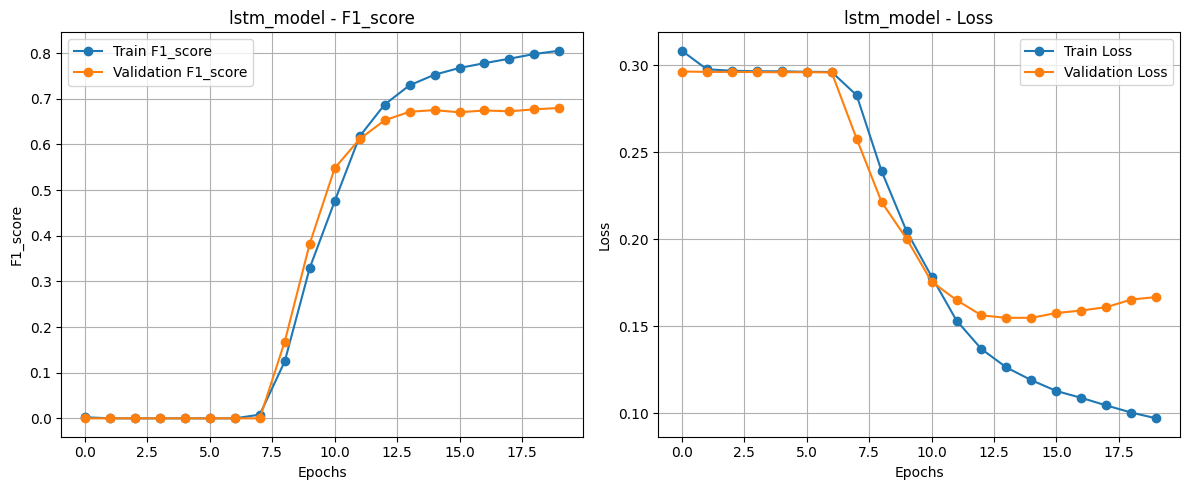

In [68]:
model_performance("lstm_model", history_lstm)

In [69]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


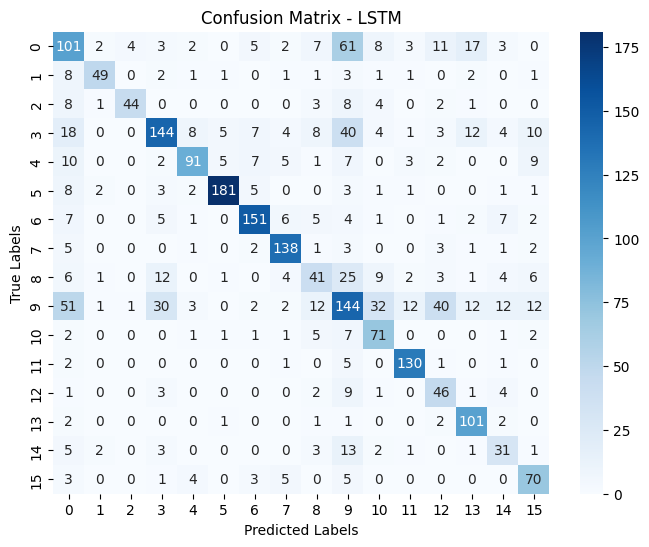

In [70]:
y_pred_lstm = lstm_model.predict(test_ds)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int) #Convertir les prédictions en labels binaires

plot_confusion_matrix(test_labels, y_pred_lstm, "LSTM")

Expérimentation 2 : Utiliser un embedding pré entraîné (Word2Vec/Glove).

In [ ]:
# Charger les embeddings GloVe
def load_glove_embeddings(glove_path, embedding_dim, word_index, vocab_size):
    embeddings_index = {}

    with open(glove_path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = vector

    print(f"{len(embeddings_index)} mots chargés depuis GloVe.")

    # Créer la matrice d'embedding
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in word_index.items():
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    return embedding_matrix

# Définition des constantes
GLOVE_PATH = "/content/glove.6B.50d.txt"
VOCAB_SIZE = min(len(word_tokenizer.word_index) + 1, MAX_NB_WORDS)  # Taille du vocabulaire

# Charger les embeddings
embedding_matrix = load_glove_embeddings(GLOVE_PATH, EMBEDDING_DIM, word_tokenizer.word_index, MAX_NB_WORDS)

In [76]:
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="text_input")

# Couche d'embedding initialisée avec Glove
embedding = layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    input_length=MAX_SEQUENCE_LENGTH,
    weights=[embedding_matrix],
    trainable=False
)(text_input)

# Première couche LSTM
x = layers.LSTM(64, return_sequences=True)(embedding)
x = layers.LSTM(64, return_sequences=False)(x)

# Couches Fully Connected
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)

# Couche de sortie
output = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)

# Création du modèle
lstm_model_glove = Model(inputs=text_input, outputs=output)

# Compilation du modèle
lstm_model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_metric])

# Affichage du résumé du modèle
lstm_model_glove.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)              │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 30, 50)              │         210,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 30, 64)              │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 283,348 (1.08 MB)

 Trainable params: 72,848 (284.56 KB)

 Non-trainable params: 210,500 (822.27 KB)

In [ ]:
history_lstm_glove = lstm_model_glove.fit(train_ds, validation_data=val_ds, epochs=20, batch_size=32)

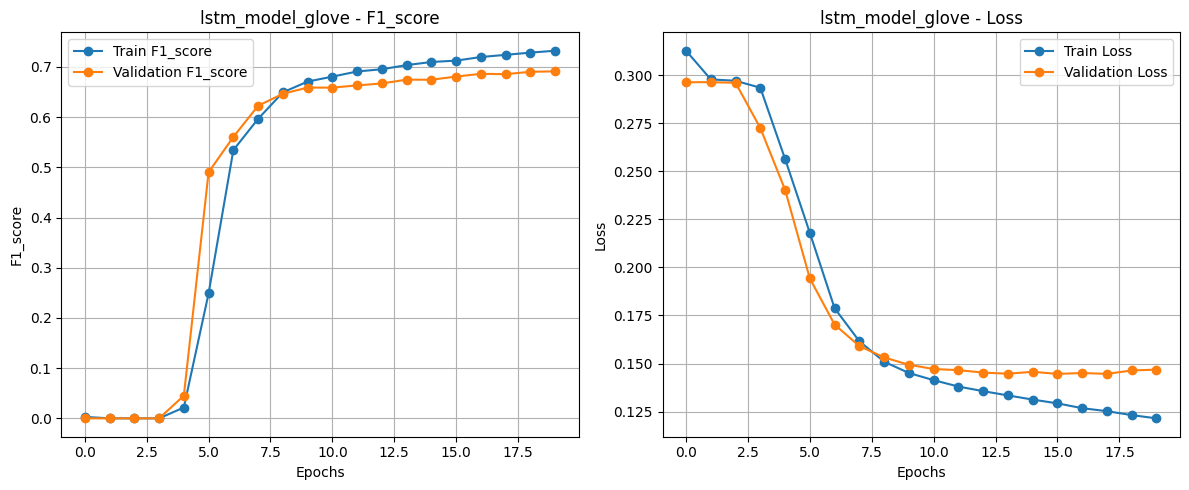

In [71]:
model_performance("lstm_model_glove", history_lstm_glove)

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


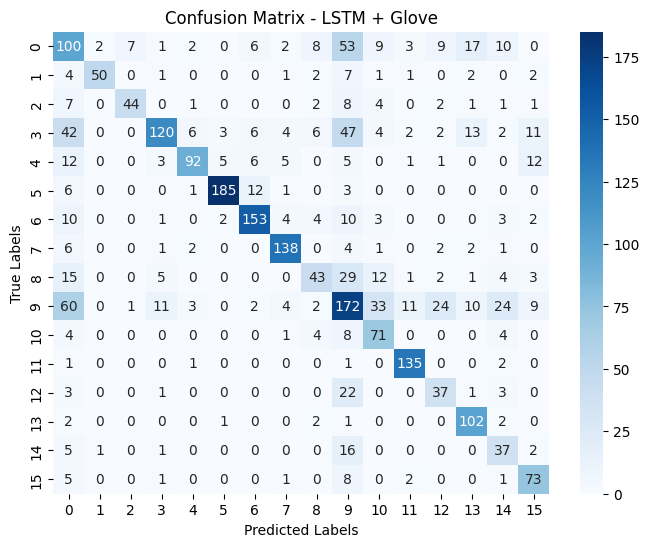

In [72]:
y_pred_lstm = lstm_model_glove.predict(test_ds)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int) #Convertir les prédictions en labels binaires

plot_confusion_matrix(test_labels, y_pred_lstm, "LSTM + Glove")

Expérimentation 3 : Construire une architecture hybride combinant LSTM et 1D CNN

In [77]:
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="text_input")

# Couche d'embedding initialisée aléatoirement
embedding = layers.Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(text_input)

# CNN 1D pour capturer les motifs locaux
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(embedding)
x = layers.MaxPooling1D(pool_size=2)(x)

# LSTM pour capturer les dépendances contextuelles
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=False)(x)  # Dernière couche LSTM

# Couches Fully Connected
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)

# Couche de sortie
output = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)  # Multilabel

# Création du modèle
hybrid_model_lstm_cnn = Model(inputs=text_input, outputs=output)

# Compilation du modèle
hybrid_model_lstm_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_metric])

# Affichage du résumé du modèle
hybrid_model_lstm_cnn.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)              │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_6 (Embedding)              │ (None, 30, 50)              │         210,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 30, 64)              │          16,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 15, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 302,996 (1.16 MB)

 Trainable params: 302,996 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_lstm_cnn = hybrid_model_lstm_cnn.fit(train_ds, validation_data=val_ds, epochs=20, batch_size=32)

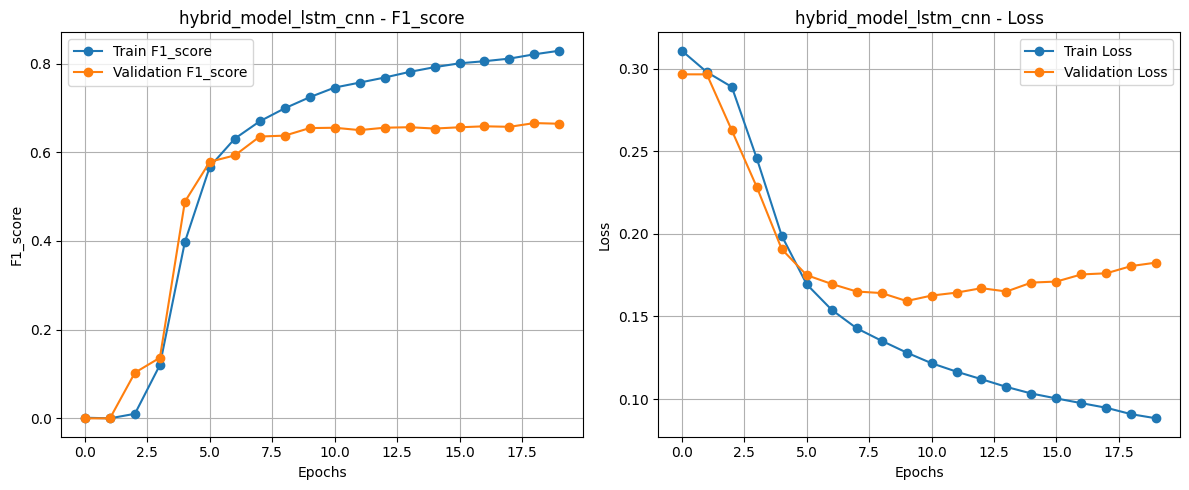

In [73]:
model_performance("hybrid_model_lstm_cnn", history_lstm_cnn)

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


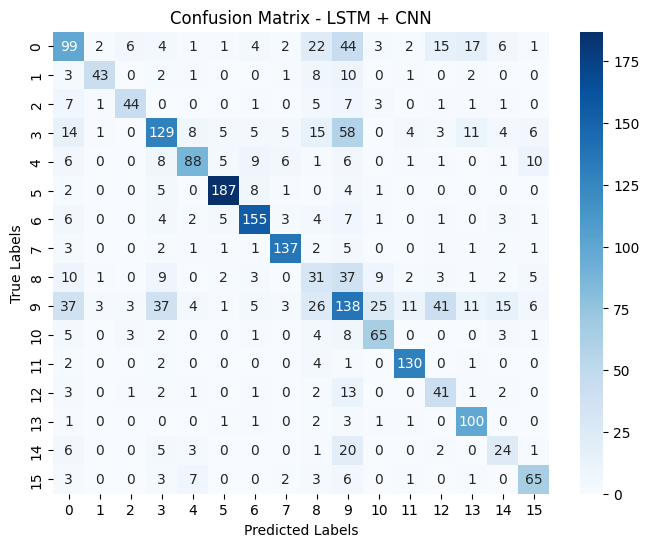

In [74]:
y_pred_lstm = hybrid_model_lstm_cnn.predict(test_ds)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int) #Convertir les prédictions en labels binaires

plot_confusion_matrix(test_labels, y_pred_lstm, "LSTM + CNN")

Expérimentation 4 : Construire une architecture hybride combinant Bi-LSTM et 1D CNN

*Le Bi-LSTM utilise deux LSTM, l'un lisant la séquence dans le sens classique (gauche → droite) et l'autre dans le sens inverse (droite → gauche).*

In [75]:
from tensorflow.keras.layers import Bidirectional

text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="text_input")

# Couche d'embedding initialisée aléatoirement
embedding = layers.Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(text_input)

# CNN 1D pour capturer les motifs locaux
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(embedding)
x = layers.MaxPooling1D(pool_size=2)(x)

# Bi-LSTM pour capturer les dépendances contextuelles dans les deux directions
x = Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = Bidirectional(layers.LSTM(64, return_sequences=False))(x)

# Couches Fully Connected
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)

# Couche de sortie
output = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)  # Multilabel

# Création du modèle
hybrid_model_bilstm_cnn = Model(inputs=text_input, outputs=output)

# Compilation du modèle
hybrid_model_bilstm_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_metric])

# Affichage du résumé du modèle
hybrid_model_bilstm_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)              │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 30, 50)              │         210,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 30, 64)              │          16,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 15, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 410,004 (1.56 MB)

 Trainable params: 410,004 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history_bilstm_cnn = hybrid_model_bilstm_cnn.fit(train_ds, validation_data=val_ds, epochs=20, batch_size=32)

Epoch 1/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - accuracy: 0.1247 - f1_metric: 0.0166 - loss: 0.3390 - val_accuracy: 0.2895 - val_f1_metric: 0.1493 - val_loss: 0.2480
Epoch 2/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.3383 - f1_metric: 0.2480 - loss: 0.2290 - val_accuracy: 0.4912 - val_f1_metric: 0.4697 - val_loss: 0.1959
Epoch 3/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.5319 - f1_metric: 0.5129 - loss: 0.1812 - val_accuracy: 0.5441 - val_f1_metric: 0.5821 - val_loss: 0.1731
Epoch 4/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.6027 - f1_metric: 0.6444 - loss: 0.1537 - val_accuracy: 0.5790 - val_f1_metric: 0.6283 - val_loss: 0.1674
Epoch 5/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.6538 - f1_metric: 0.6942 - loss: 0.1394 - val_accuracy: 0.5996 - val_f1_metric: 0.6390 - val_loss: 0.1623
Epoch 6/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.6808 - f1_metric: 0.7179 - loss: 0.1302 - val_accuracy: 0.6113

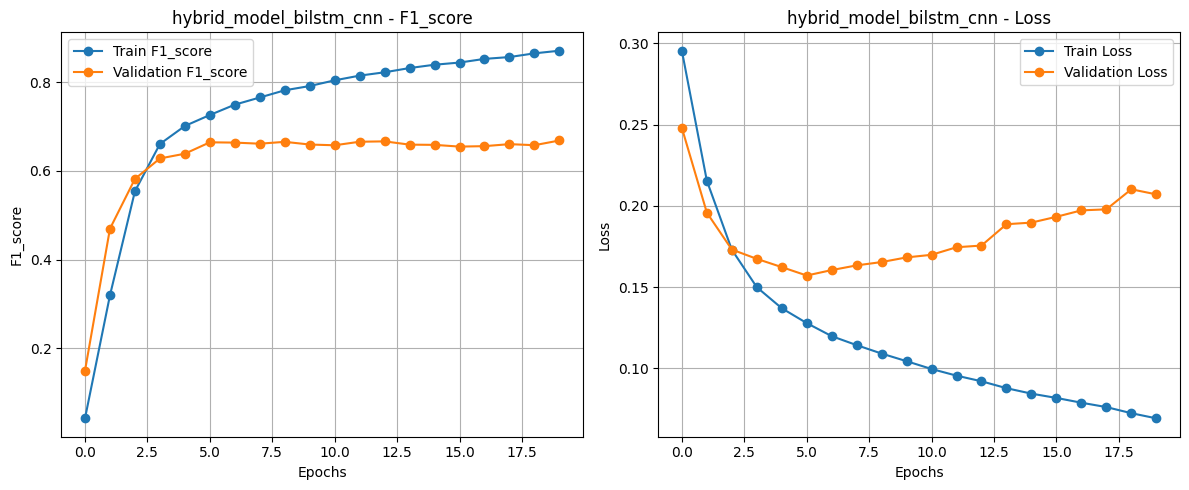

In [48]:
model_performance("hybrid_model_bilstm_cnn", history_bilstm_cnn)

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


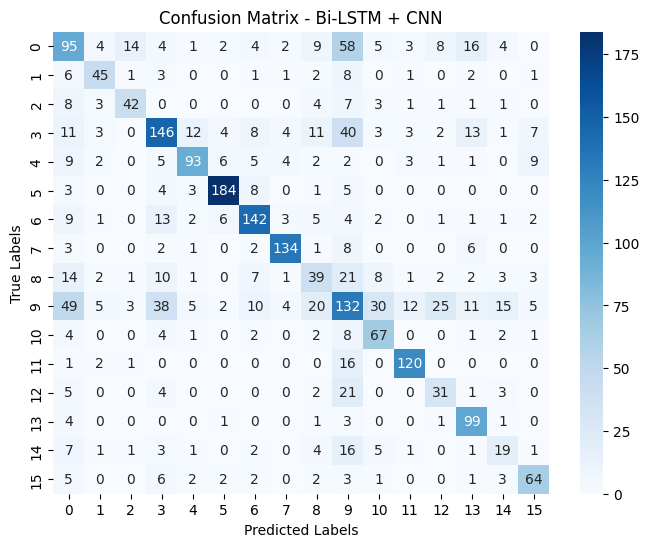

In [49]:
y_pred_bilstm = hybrid_model_bilstm_cnn.predict(test_ds)
y_pred_bilstm = (y_pred_bilstm > 0.5).astype(int) #Convertir les prédictions en labels binaires

plot_confusion_matrix(test_labels, y_pred_bilstm, "Bi-LSTM + CNN")

####Comparaison des résultats et choix du modèle final


Comparer les performances des différents modèles expérimentés à l’aide de la matrice de confusion et des métriques sélectionnées, adaptées à la classification multi-label.

- Les modèles LSTM + CNN et le Bi-LSTM ont des valeurs plus concentrées sur la diagonale que le modèle LSTM from scratch et LSTM + Glove. Les modèles présentes des courbes f1 score autour de 0.8 après 20 epocs.

- Le LSTM + CNN est meilleur que le Bi-LSTM + CNN sur les données de validation.

- Les modèles LSTM from scratch et LSTM + Glove montre plus de dispersion des prédictions incorrectes, ce qui signifie plus de confusion entre les classes.

- Dans certaines classes, LSTM + CNN améliore les performances (ex : la classe 3, où il prédit 162 correctement contre 143 et 118 pour LSTM from scratch et LSTM + Glove).

Justifier le choix du modèle retenu.

*Nous avons choisi le modèle LSTM + CNN car il combine les avantages des deux architectures : le LSTM capture les dépendances contextuelles dans les séquences de texte, tandis que le CNN extrait efficacement des motifs locaux. La matrice de confusion montre une meilleure répartition des prédictions correctes par rapport au modèle LSTM seul, indiquant une amélioration des performances globales. Et le LSTM + CNN est meilleur que le Bi-LSTM + CNN sur les données de validation.*

####Analyse des résultats

Afficher quelques textes de test avec les prédictions et les scores de confiance correspondants.
  

In [62]:
true_labels = test_labels[1]
true_labels

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [66]:
def decode_sequence(sequence, tokenizer):
    """Decodes a sequence of token IDs back into text."""
    decoded_text = " ".join([tokenizer.index_word.get(idx, "0") for idx in sequence])
    return decoded_text

num_examples = 5

# Convert test_ds to a NumPy array for indexing
test_ds_numpy = list(test_ds.as_numpy_iterator())

for i in range(num_examples):
    example_text = decode_sequence(test_padded[i], word_tokenizer)
    prediction_probabilities = hybrid_model_lstm_cnn.predict(np.expand_dims(test_ds_numpy[i][0][0], axis=0))
    predicted_labels = (prediction_probabilities > 0.5).astype(int)[0]
    true_labels = test_labels[i]

    print(f"Text Example {i + 1}: {example_text}")
    print(f"Predicted Labels: {predicted_labels}")
    print(f"     True Labels: {true_labels}")
    print(f"Prediction Confidence Scores: {prediction_probabilities[0]}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Text Example 1: elephant standing grass covered field 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Predicted Labels: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
     True Labels: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Prediction Confidence Scores: [0.02119557 0.00662387 0.00506117 0.23082882 0.00282185 0.00385989
 0.01071256 0.00132192 0.02524253 0.91533923 0.0123006  0.00477196
 0.02821853 0.00120032 0.15474021 0.00102758]
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Text Example 2: people pulling suitcases walking road 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Predicted Labels: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
     True Labels: [1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
Prediction Confidence Scores: [2.37677014e-03 4.81746905e-03 5.08189492e-04 9.94350374e-01
 1.07739838e-02 1.46407424e-03 1.36852935e-02 1.28454168e-03
 3.82557288e-02 4.35474403e-02 7.77084933e-05 2.43431958e-03
 4.83316509e-03 5.23955328e-04 1.5

Utiliser des techniques d’interprétation, comme LIME, pour mieux comprendre les décisions du modèle.
  

In [51]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a36652ea423757d1bff1ac160d4ad83de01b95981fc00dcb1f2063e97100e789
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [52]:
!pip install lime-text

ERROR: Could not find a version that satisfies the requirement lime-text (from versions: none)
ERROR: No matching distribution found for lime-text


In [ ]:
import lime
from lime.lime_text import LimeTextExplainer
from skimage.segmentation import mark_boundaries

In [54]:
# Créer l'explainer pour le texte
explainer = lime.lime_text.LimeTextExplainer(class_names=["Classe {}".format(i) for i in range(NUM_CLASSES)])

# Sélectionner un texte de test
test_index = np.random.randint(0, len(X_test))  # Sélection aléatoire d'un texte
test_text = X_test[test_index]
test_label = test_labels[test_index]

original_text = " ".join([word_tokenizer.index_word.get(idx, "UNK") for idx in test_text])

# Fonction de prédiction adaptée à LIME
def predict_fn(texts):
    sequences = word_tokenizer.texts_to_sequences(texts)  # Tokenisation des textes
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)  # Padding
    return hybrid_model_lstm_cnn.predict(padded_sequences)  # Prédictions

# Explication de la prédiction avec LIME
explanation = explainer.explain_instance(
    original_text, predict_fn, num_features=10, top_labels=1 #Using original_text
)

# Affichage des mots les plus influents dans la prédiction
explanation.show_in_notebook(text=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


Examiner des erreurs de prédiction et essayer d’identifier des explications.


- Le modèle a raté les labels 1, 9 et 10 malgré une probabilité non négligeable pour 9 et 10 (3.8% et 4.3%). Il a activé à tort le label 4 avec très forte confiance (99.4%).
- Le modèle a activé à tort le label 3 avec une confiance très élevée (99.8%). En revanche, il a complètement ignoré les vrais labels (15 et 16) malgré une probabilité faible (4.5% et 2.2%).
- Le modèle a préféré un label 10 incorrect (96.2%) au vrai label 6 (seulement 0.4%).
- Le modèle a encore activé le label 4 avec une confiance élevée (94.6%) alors que le vrai label 6 est ignoré.

Interpréter les résultats et proposer des pistes d’amélioration.

Les labels incorrects sont activés avec des probabilités élevées (ex : 99.4%, 99.8%, 96.2%). Cela suggère un surapprentissage sur certains patterns dans les données d’entraînement.
Comme piste d'amélioration, on pourrait :
- Réequilibrer les données
- Utiliser l'embeding glove avec le modèle LSTM + CNN